<a href="https://colab.research.google.com/github/Mahaboob-Ashraf/skin-disease-detection/blob/main/skin_disease_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **---------------------   Skin Lesion Classification System   ---------------------**

---





# **Part 1: Exploration and Preprocessing.**

## Loading the data set:

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mahaboobashraf","key":"863a19a8088ad9e28ce449ca0c0cc85d"}'}

In [2]:
#Setup:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
#Downloading and unzippng:

#createing a folder
!mkdir -p /content/data/ham10000

# Downloading HAM10000 dataset
!kaggle datasets download -d kmader/skin-cancer-mnist-ham10000 -p /content/data/ham10000

# Unzipping into the same folder
!unzip -q /content/data/ham10000/skin-cancer-mnist-ham10000.zip -d /content/data/ham10000

# Listing contents to verify
!ls -lh /content/data/ham10000 | head -20

Dataset URL: https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000
License(s): CC-BY-NC-SA-4.0
100% 5.17G/5.20G [01:51<00:00, 54.2MB/s]
100% 5.20G/5.20G [01:52<00:00, 49.6MB/s]
total 5.4G
drwxr-xr-x 2 root root 180K Sep 16 07:21 ham10000_images_part_1
drwxr-xr-x 2 root root 180K Sep 16 07:20 HAM10000_images_part_1
drwxr-xr-x 2 root root 168K Sep 16 07:21 ham10000_images_part_2
drwxr-xr-x 2 root root 168K Sep 16 07:20 HAM10000_images_part_2
-rw-r--r-- 1 root root 551K Oct  6  2019 HAM10000_metadata.csv
-rw-r--r-- 1 root root  30M Oct  6  2019 hmnist_28_28_L.csv
-rw-r--r-- 1 root root  88M Oct  6  2019 hmnist_28_28_RGB.csv
-rw-r--r-- 1 root root 2.5M Oct  6  2019 hmnist_8_8_L.csv
-rw-r--r-- 1 root root 7.2M Oct  6  2019 hmnist_8_8_RGB.csv
-rw-r--r-- 1 root root 5.2G Oct  6  2019 skin-cancer-mnist-ham10000.zip


## Exploratory Data Analysis (EDA):

In [4]:
#Load CSV & preview:
import pandas as pd

meta_path = "/content/data/ham10000/HAM10000_metadata.csv"
df = pd.read_csv(meta_path)

print("Shape of metadata:", df.shape)
df.head()

Shape of metadata: (10015, 7)


,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64


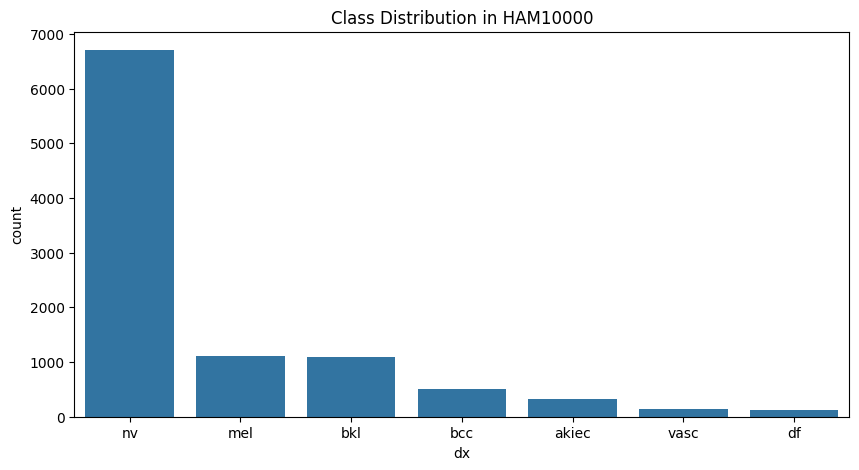

In [5]:
#Class distribution:

# Value counts of the 'dx' column (diagnosis)
class_counts = df['dx'].value_counts()
print(class_counts)

# Map short codes to full names for clarity
class_map = {
    'akiec': 'Actinic keratoses',
    'bcc': 'Basal cell carcinoma',
    'bkl': 'Benign keratosis-like lesions',
    'df': 'Dermatofibroma',
    'mel': 'Melanoma',
    'nv': 'Melanocytic nevi',
    'vasc': 'Vascular lesions'
}

df['dx_full'] = df['dx'].map(class_map)

# Plot distribution
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.countplot(data=df, x='dx', order=class_counts.index)
plt.title("Class Distribution in HAM10000")
plt.show()

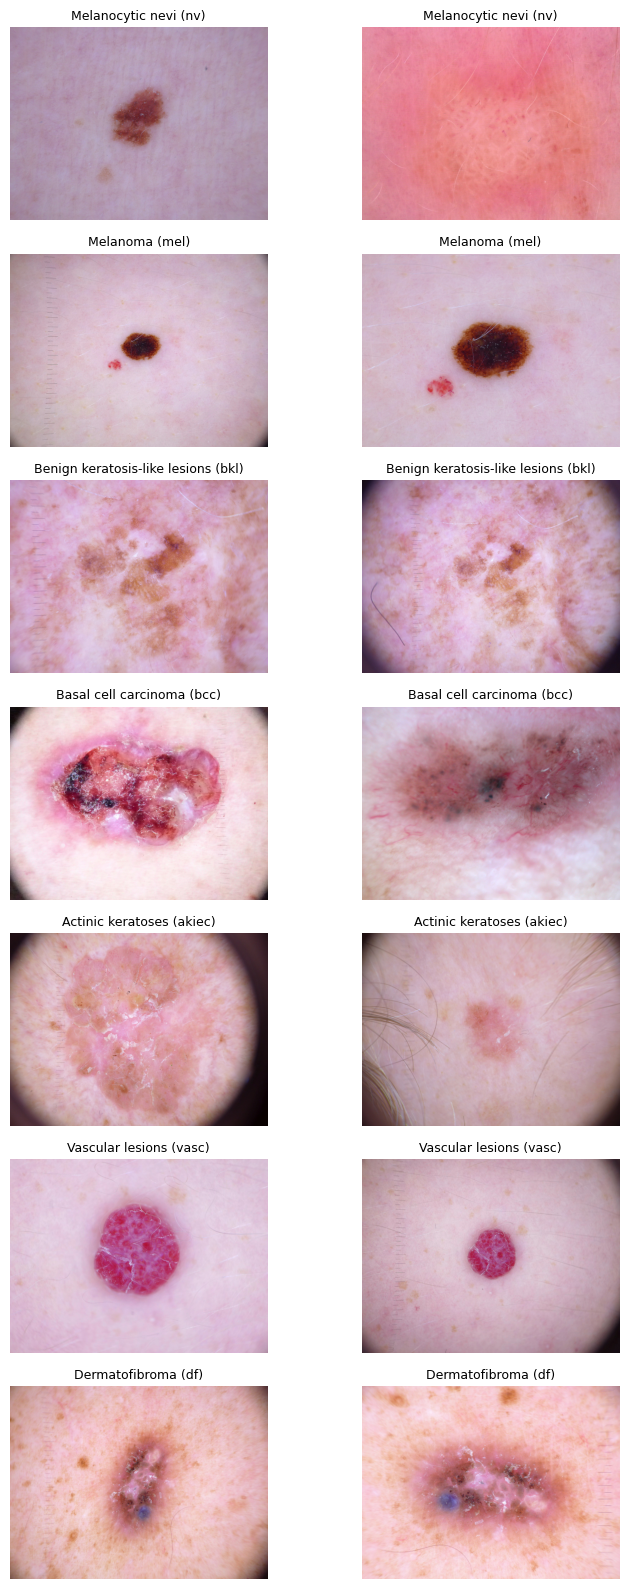

In [6]:
#Add image paths & preview samples:

# Robust preview cell — maps image IDs if needed, then displays up to 2 samples per class
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# If image_path not created yet, create it (handles both image parts)
if 'image_path' not in df.columns or df['image_path'].isna().any():
    IMG_BASE = "/content/data/ham10000"
    IMG_DIR1 = os.path.join(IMG_BASE, "ham10000_images_part_1")
    IMG_DIR2 = os.path.join(IMG_BASE, "ham10000_images_part_2")
    def find_image_path(img_id):
        fname = img_id + ".jpg"
        p1 = os.path.join(IMG_DIR1, fname)
        if os.path.exists(p1):
            return p1
        p2 = os.path.join(IMG_DIR2, fname)
        if os.path.exists(p2):
            return p2
        return None
    df['image_path'] = df['image_id'].apply(find_image_path)
    df = df.dropna(subset=['image_path']).reset_index(drop=True)

# Ensure dx_full exists
if 'dx_full' not in df.columns:
    class_map = {
        'akiec': 'Actinic keratoses',
        'bcc': 'Basal cell carcinoma',
        'bkl': 'Benign keratosis-like lesions',
        'df': 'Dermatofibroma',
        'mel': 'Melanoma',
        'nv': 'Melanocytic nevi',
        'vasc': 'Vascular lesions'
    }
    df['dx_full'] = df['dx'].map(class_map)

# Prepare samples: up to 2 images per class (handles classes with <2 images)
SAMPLES_PER_CLASS = 2
samples = {}
for cls, group in df.groupby('dx'):
    valid = group[group['image_path'].apply(lambda p: p is not None and os.path.exists(p))]
    if len(valid) > 0:
        samples[cls] = valid.head(SAMPLES_PER_CLASS)

classes = sorted(samples.keys(), key=lambda x: list(df['dx'].value_counts().index).index(x))
n = len(classes)
if n == 0:
    raise RuntimeError("No valid image files found. Re-run the mapping step and confirm image folders exist.")

cols = SAMPLES_PER_CLASS
rows = n
fig_w = max(8, cols * 4)
fig_h = max(2 + rows * 2, rows * 2.2)
fig, axes = plt.subplots(rows, cols, figsize=(fig_w, fig_h))

# Normalize axes shape for single-row or single-col cases
if rows == 1:
    axes = axes.reshape(1, -1)
if cols == 1:
    axes = axes.reshape(-1, 1)

for i, cls in enumerate(classes):
    rows_df = samples[cls].reset_index(drop=True)
    for j in range(cols):
        ax = axes[i, j]
        if j < len(rows_df):
            img_path = rows_df.loc[j, 'image_path']
            try:
                img = mpimg.imread(img_path)
                ax.imshow(img)
                ax.set_title(f"{rows_df.loc[j, 'dx_full']} ({rows_df.loc[j, 'dx']})", fontsize=9)
            except Exception as e:
                ax.text(0.5, 0.5, "Image read error", ha='center', va='center')
            ax.axis('off')
        else:
            ax.axis('off')

plt.tight_layout()
plt.show()



## Preprocessing & Data Pipeline:




In [7]:
#Stratified train / val / test split:

from sklearn.model_selection import train_test_split
SEED = 42

train_df, temp_df = train_test_split(df, test_size=0.30, stratify=df['dx'], random_state=SEED)
val_df, test_df  = train_test_split(temp_df, test_size=0.50, stratify=temp_df['dx'], random_state=SEED)

print("Train:", len(train_df), "Val:", len(val_df), "Test:", len(test_df))
train_df['dx'].value_counts(), val_df['dx'].value_counts(), test_df['dx'].value_counts()


Train: 7010 Val: 1502 Test: 1503


(dx
 nv       4693
 mel       779
 bkl       769
 bcc       360
 akiec     229
 vasc       99
 df         81
 Name: count, dtype: int64,
 dx
 nv       1006
 mel       167
 bkl       165
 bcc        77
 akiec      49
 vasc       21
 df         17
 Name: count, dtype: int64,
 dx
 nv       1006
 mel       167
 bkl       165
 bcc        77
 akiec      49
 vasc       22
 df         17
 Name: count, dtype: int64)

In [8]:
#Data augmentation & normalization (generators config):

from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = 224
BATCH_SIZE = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.08,
    height_shift_range=0.08,
    shear_range=0.08,
    zoom_range=0.12,
    brightness_range=(0.8,1.2),
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)


In [9]:
#Building generators (using image_path & dx):

train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='dx',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

val_gen = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='image_path',
    y_col='dx',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_gen = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='dx',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

# Quick mapping info
print("Class indices:", train_gen.class_indices)


Found 7010 validated image filenames belonging to 7 classes.
Found 1502 validated image filenames belonging to 7 classes.
Found 1503 validated image filenames belonging to 7 classes.
Class indices: {'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}


In [10]:
#Computing class weights (for imbalanced classes):

from sklearn.utils.class_weight import compute_class_weight
import numpy as np

labels = train_df['dx'].values
classes = np.unique(labels)
raw_weights = compute_class_weight(class_weight='balanced', classes=classes, y=labels)
# Map label string -> index used by generator
label_to_index = train_gen.class_indices  # e.g. {'nv':0, 'mel':1, ...}
# Build dict expected by model.fit: index -> weight
class_weights = { label_to_index[cls] : float(raw_weights[i]) for i, cls in enumerate(classes) }
print("Class weights (index -> weight):", class_weights)


Class weights (index -> weight): {0: 4.37305053025577, 1: 2.7817460317460316, 2: 1.3022478172023035, 3: 12.36331569664903, 4: 1.285530900421786, 5: 0.21338772031292808, 6: 10.115440115440116}


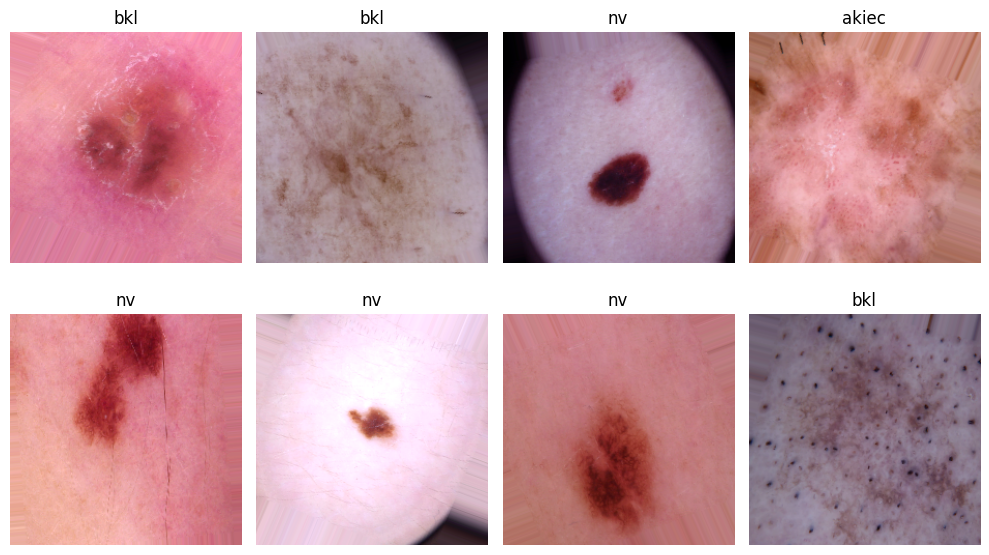

In [11]:
#Verifying one training batch visually:

import matplotlib.pyplot as plt
import numpy as np

batch_x, batch_y = next(train_gen)
plt.figure(figsize=(10,6))
for i in range(min(8, len(batch_x))):
    ax = plt.subplot(2,4,i+1)
    plt.imshow(batch_x[i])
    label_idx = np.argmax(batch_y[i])
    # reverse map index -> label
    idx_to_label = {v:k for k,v in train_gen.class_indices.items()}
    plt.title(idx_to_label[label_idx])
    plt.axis('off')
plt.tight_layout()
plt.show()


In [12]:
#Saving the splited data:

train_df.to_csv('data/train_split.csv', index=False)
val_df.to_csv('data/val_split.csv', index=False)
test_df.to_csv('data/test_split.csv', index=False)


---

# **Part 2: Model building and training.**





## Building the CNN Architecture:

In [13]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, BatchNormalization, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam

def build_advanced_cnn(input_shape=(224, 224, 3), num_classes=7):
    # Define the input tensor
    input_ = Input(shape=input_shape)

    # --- Convolutional Blocks with L2 Regularization ---
    # Block 1
    x = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal',
               kernel_regularizer=tf.keras.regularizers.l2(0.001))(input_)
    x = MaxPooling2D()(x)
    x = BatchNormalization()(x)

    # Block 2
    x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal',
               kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal',
               kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = MaxPooling2D()(x)
    x = BatchNormalization()(x)

    # Block 3
    x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal',
               kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal',
               kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = MaxPooling2D()(x)
    x = BatchNormalization()(x)

    # Block 4
    x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal',
               kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal',
               kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = MaxPooling2D()(x)
    x = BatchNormalization()(x)

    # --- Head / Classifier ---
    x = Flatten()(x)
    x = Dropout(rate=0.3)(x)
    x = Dense(units=256, activation='relu', kernel_initializer='he_normal',
              kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dense(units=128, activation='relu', kernel_initializer='he_normal',
              kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dense(units=64, activation='relu', kernel_initializer='he_normal',
              kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = BatchNormalization()(x)
    x = Dense(units=32, activation='relu', kernel_initializer='he_normal')(x) # Removed one regularizer for variety
    x = BatchNormalization()(x)

    # Output layer
    output = Dense(units=num_classes, activation='softmax', kernel_initializer="glorot_uniform")(x)

    # Create the model
    model = Model(inputs=input_, outputs=output)
    return model

# Initialize and compile the new model
model = build_advanced_cnn()
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    12,845,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 14,055,623 (53.62 MB)

 Trainable params: 14,053,703 (53.61 MB)

 Non-trainable params: 1,920 (7.50 KB)

## Training the Model:

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# Define callbacks, saving the new model locally to a new file name.
checkpoint = ModelCheckpoint('best_model_advanced.h5', monitor='val_loss', save_best_only=True, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model using your existing variables
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30, # Increased epochs for this deeper model
    callbacks=[checkpoint, reduce_lr, early_stopping],
    class_weight=class_weights
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 671ms/step - accuracy: 0.2241 - loss: 4.9700

220/220 ━━━━━━━━━━━━━━━━━━━━ 193s 763ms/step - accuracy: 0.2244 - loss: 4.9688 - val_accuracy: 0.0639 - val_loss: 5.3652 - learning_rate: 1.0000e-04
Epoch 2/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 611ms/step - accuracy: 0.3408 - loss: 4.4762

220/220 ━━━━━━━━━━━━━━━━━━━━ 150s 681ms/step - accuracy: 0.3409 - loss: 4.4758 - val_accuracy: 0.3076 - val_loss: 4.5430 - learning_rate: 1.0000e-04
Epoch 3/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 591ms/step - accuracy: 0.3742 - loss: 4.2928

220/220 ━━━━━━━━━━━━━━━━━━━━ 141s 639ms/step - accuracy: 0.3743 - loss: 4.2926 - val_accuracy: 0.4481 - val_loss: 4.3932 - learning_rate: 1.0000e-04
Epoch 4/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 138s 626ms/step - accuracy: 0.3888 - loss: 4.2807 - val_accuracy: 0.4134 - val_loss: 4.4403 - learning_rate: 1.0000e-04
Epoch 5/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step - accuracy: 0.4024 - loss: 4.1495

220/220 ━━━━━━━━━━━━━━━━━━━━ 141s 640ms/step - accuracy: 0.4024 - loss: 4.1497 - val_accuracy: 0.4687 - val_loss: 4.3816 - learning_rate: 1.0000e-04
Epoch 6/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 592ms/step - accuracy: 0.4311 - loss: 4.1949

220/220 ━━━━━━━━━━━━━━━━━━━━ 145s 660ms/step - accuracy: 0.4311 - loss: 4.1948 - val_accuracy: 0.4860 - val_loss: 4.2454 - learning_rate: 1.0000e-04
Epoch 7/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 140s 638ms/step - accuracy: 0.4549 - loss: 4.0245 - val_accuracy: 0.4634 - val_loss: 4.3000 - learning_rate: 1.0000e-04
Epoch 8/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 592ms/step - accuracy: 0.4681 - loss: 4.0633

220/220 ━━━━━━━━━━━━━━━━━━━━ 145s 654ms/step - accuracy: 0.4680 - loss: 4.0633 - val_accuracy: 0.4834 - val_loss: 4.2433 - learning_rate: 1.0000e-04
Epoch 9/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 592ms/step - accuracy: 0.4765 - loss: 4.0238

220/220 ━━━━━━━━━━━━━━━━━━━━ 203s 657ms/step - accuracy: 0.4765 - loss: 4.0239 - val_accuracy: 0.5280 - val_loss: 4.1427 - learning_rate: 1.0000e-04
Epoch 10/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 143s 650ms/step - accuracy: 0.4642 - loss: 4.0183 - val_accuracy: 0.4987 - val_loss: 4.3007 - learning_rate: 1.0000e-04
Epoch 11/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 142s 643ms/step - accuracy: 0.4628 - loss: 4.1053 - val_accuracy: 0.5013 - val_loss: 4.2733 - learning_rate: 1.0000e-04
Epoch 12/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 607ms/step - accuracy: 0.4639 - loss: 4.1187

220/220 ━━━━━━━━━━━━━━━━━━━━ 149s 676ms/step - accuracy: 0.4638 - loss: 4.1186 - val_accuracy: 0.5340 - val_loss: 4.1188 - learning_rate: 1.0000e-04
Epoch 13/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 147s 667ms/step - accuracy: 0.4753 - loss: 4.1110 - val_accuracy: 0.5379 - val_loss: 4.1476 - learning_rate: 1.0000e-04
Epoch 14/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 144s 652ms/step - accuracy: 0.5016 - loss: 3.9776 - val_accuracy: 0.5067 - val_loss: 4.1405 - learning_rate: 1.0000e-04
Epoch 15/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 597ms/step - accuracy: 0.4846 - loss: 3.9864

220/220 ━━━━━━━━━━━━━━━━━━━━ 146s 662ms/step - accuracy: 0.4847 - loss: 3.9863 - val_accuracy: 0.5166 - val_loss: 4.1024 - learning_rate: 1.0000e-04
Epoch 16/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 143s 648ms/step - accuracy: 0.4974 - loss: 3.9047 - val_accuracy: 0.4814 - val_loss: 4.1727 - learning_rate: 1.0000e-04
Epoch 17/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 606ms/step - accuracy: 0.4924 - loss: 3.9267

220/220 ━━━━━━━━━━━━━━━━━━━━ 145s 661ms/step - accuracy: 0.4924 - loss: 3.9266 - val_accuracy: 0.5153 - val_loss: 4.0806 - learning_rate: 1.0000e-04
Epoch 18/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 146s 662ms/step - accuracy: 0.4967 - loss: 3.7949 - val_accuracy: 0.4854 - val_loss: 4.2820 - learning_rate: 1.0000e-04
Epoch 19/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 143s 651ms/step - accuracy: 0.4862 - loss: 4.0652 - val_accuracy: 0.4900 - val_loss: 4.2955 - learning_rate: 1.0000e-04
Epoch 20/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 610ms/step - accuracy: 0.4731 - loss: 4.1045

220/220 ━━━━━━━━━━━━━━━━━━━━ 149s 676ms/step - accuracy: 0.4731 - loss: 4.1043 - val_accuracy: 0.5293 - val_loss: 4.0302 - learning_rate: 1.0000e-04
Epoch 21/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 141s 642ms/step - accuracy: 0.4864 - loss: 3.9809 - val_accuracy: 0.4893 - val_loss: 4.1406 - learning_rate: 1.0000e-04
Epoch 22/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 594ms/step - accuracy: 0.4835 - loss: 4.1193

220/220 ━━━━━━━━━━━━━━━━━━━━ 146s 661ms/step - accuracy: 0.4835 - loss: 4.1187 - val_accuracy: 0.5100 - val_loss: 4.0105 - learning_rate: 1.0000e-04
Epoch 23/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 591ms/step - accuracy: 0.5060 - loss: 3.9197

220/220 ━━━━━━━━━━━━━━━━━━━━ 201s 657ms/step - accuracy: 0.5060 - loss: 3.9196 - val_accuracy: 0.5672 - val_loss: 3.8832 - learning_rate: 1.0000e-04
Epoch 24/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 142s 644ms/step - accuracy: 0.4976 - loss: 3.8894 - val_accuracy: 0.5300 - val_loss: 3.9925 - learning_rate: 1.0000e-04
Epoch 25/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 141s 640ms/step - accuracy: 0.5130 - loss: 3.8038 - val_accuracy: 0.5320 - val_loss: 4.0283 - learning_rate: 1.0000e-04
Epoch 26/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 596ms/step - accuracy: 0.5217 - loss: 3.8001

220/220 ━━━━━━━━━━━━━━━━━━━━ 142s 644ms/step - accuracy: 0.5217 - loss: 3.8001 - val_accuracy: 0.5692 - val_loss: 3.8607 - learning_rate: 1.0000e-04
Epoch 27/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 140s 635ms/step - accuracy: 0.5318 - loss: 3.8041 - val_accuracy: 0.5586 - val_loss: 3.8660 - learning_rate: 1.0000e-04
Epoch 28/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 141s 639ms/step - accuracy: 0.5386 - loss: 3.6746 - val_accuracy: 0.5752 - val_loss: 3.8629 - learning_rate: 1.0000e-04
Epoch 29/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 0s 591ms/step - accuracy: 0.5249 - loss: 3.7425

220/220 ━━━━━━━━━━━━━━━━━━━━ 145s 657ms/step - accuracy: 0.5249 - loss: 3.7425 - val_accuracy: 0.5879 - val_loss: 3.7591 - learning_rate: 1.0000e-04
Epoch 30/30
220/220 ━━━━━━━━━━━━━━━━━━━━ 142s 645ms/step - accuracy: 0.5035 - loss: 3.9859 - val_accuracy: 0.4907 - val_loss: 4.0669 - learning_rate: 1.0000e-04


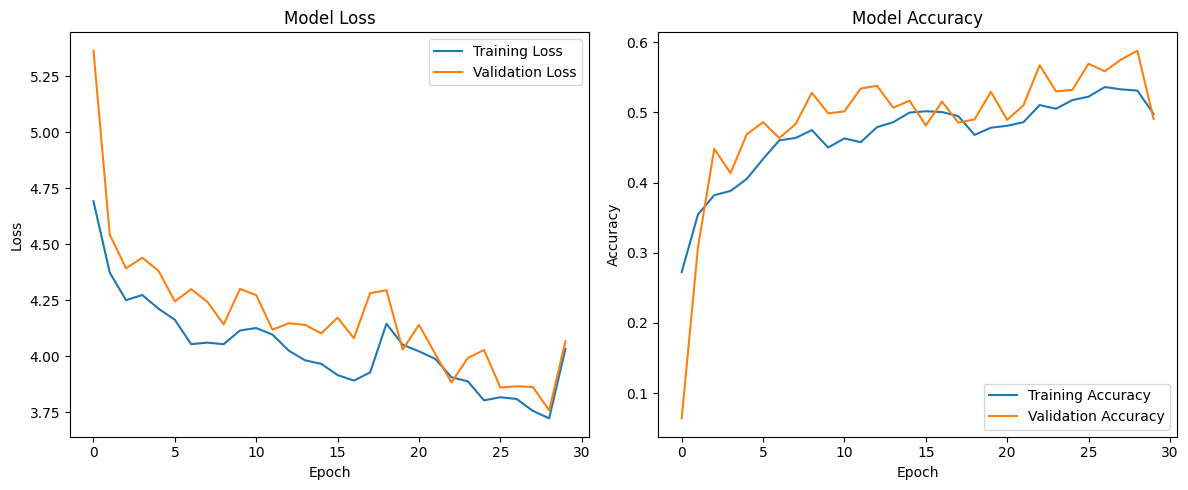

In [15]:
# Visualizing the trend of loss/accuracy

import matplotlib.pyplot as plt

# Plots training & validation loss values
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

# Plots training & validation accuracy values
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()

---

# **Part 3: Evaluation.**

##  Classification report and Confusion matrix:

Best model loaded successfully.
1503/1503 ━━━━━━━━━━━━━━━━━━━━ 18s 10ms/step - accuracy: 0.5696 - loss: 3.7318

Test Accuracy: 57.29%
Test Loss: 3.7588
1503/1503 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step

Classification Report:
              precision    recall  f1-score   support

       akiec       0.23      0.45      0.30        49
         bcc       0.39      0.53      0.45        77
         bkl       0.39      0.42      0.41       165
          df       0.09      0.41      0.14        17
         mel       0.29      0.58      0.39       167
          nv       0.96      0.60      0.74      1006
        vasc       0.25      0.86      0.39        22

    accuracy                           0.57      1503
   macro avg       0.37      0.55      0.40      1503
weighted avg       0.75      0.57      0.62      1503


Confusion Matrix:


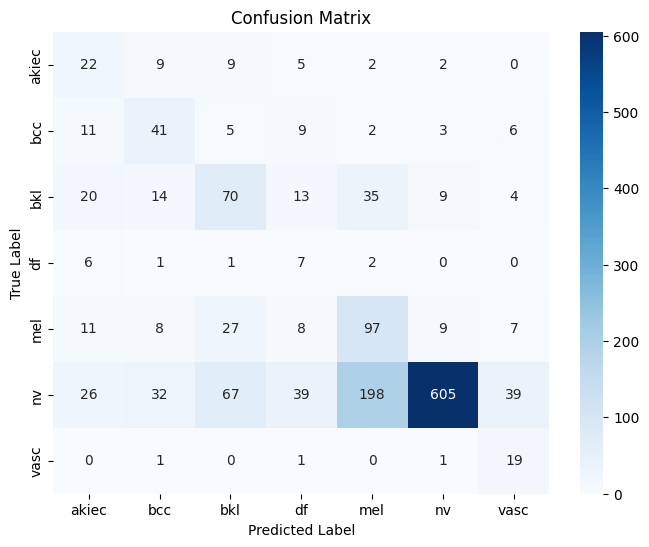

In [17]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Load the best model saved during training
model = load_model('best_model_advanced.h5')
print("Best model loaded successfully.")

# Evaluate the model on the test data
loss, accuracy = model.evaluate(test_gen, steps=len(test_gen))
print(f"\nTest Accuracy: {accuracy*100:.2f}%")
print(f"Test Loss: {loss:.4f}")

# Generate predictions
y_pred_proba = model.predict(test_gen, steps=len(test_gen))
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = test_gen.classes
class_names = list(test_gen.class_indices.keys())

# Display Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

# Display Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()



---



# **Findings (Why it went wrong):**
My initial approach was to build a Convolutional Neural Network (CNN) from scratch to classify the 7 types of skin lesions in the HAM10000 dataset. I implemented a standard data pipeline including a stratified train-validation-test split, data augmentation to increase robustness, and class weights to address the severe class imbalance.

After training, my model achieved a final test accuracy of approximately 57%.

While the model did learn some basic patterns, its performance was ultimately limited. The detailed classification report revealed that my model completely failed to identify certain rare classes (like bcc) and struggled significantly with the class imbalance, as evidenced by the large gap between the macro and weighted F1-scores. A notable finding was the high recall for melanoma, suggesting the class weights successfully pushed the model to be cautious with dangerous cases, but this came at the cost of overall accuracy and many false positives.

## Conclusion:
 While using techniques like class weights is the correct strategy, building a model's visual understanding entirely from scratch on this complex and imbalanced dataset is insufficient. The model was unable to learn the sophisticated features required for a high-accuracy diagnosis, which justifies moving to a more powerful transfer learning approach.



---

# **Possible solution:**

 Using **Transfer Learning** with a pre-trained **ResNet50** model, which already has an expert-level understanding of visual features.


## Step 1: Import PyTorch and Additional Libraries

In [ ]:
# --- PyTorch & ML ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.utils.class_weight import compute_class_weight

# --- Computer Vision & Image Handling ---
import torchvision.models as models
from torchvision import transforms
from PIL import Image

# --- Utilities ---
from tqdm import tqdm


## Step 2: Calculate Class Weights

In [ ]:
# --- 1. CREATE THE INTEGER 'LABEL' COLUMN ---
# We first need to map the string labels (like 'akiec', 'bcc') to integers (0, 1, etc.)
label_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
label_to_int = {name: i for i, name in enumerate(label_names)}

# Apply this mapping to your existing DataFrames
train_df['label'] = train_df['dx'].map(label_to_int)
val_df['label'] = val_df['dx'].map(label_to_int)
test_df['label'] = test_df['dx'].map(label_to_int)


# --- 2. CALCULATE CLASS WEIGHTS ---
# Now we can calculate weights from the new integer 'label' column
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['label']),
    y=train_df['label'].values
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
print(f"\n✅ Class weights calculated and moved to {device}.")


✅ Class weights calculated and moved to cuda.


## Step 3: Create PyTorch Datasets and DataLoaders

In [ ]:
# Custom Dataset class
class SkinDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_path = self.df['image_path'].iloc[idx]
        label = self.df['label'].iloc[idx]
        image = Image.open(image_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# Data transforms
input_size = 224
train_transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Create datasets from the existing DataFrames
train_dataset = SkinDataset(train_df, transform=train_transform)
val_dataset = SkinDataset(val_df, transform=val_test_transform)
test_dataset = SkinDataset(test_df, transform=val_test_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=2)

print("\n✅ PyTorch Datasets and DataLoaders created successfully with the correct column name.")


✅ PyTorch Datasets and DataLoaders created successfully with the correct column name.


## Step 4: Creating the **ResNet50** Architecture

In [ ]:

model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# Replace the final layer to match the 7 classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 7)
model = model.to(device)

# DEFINING THE WEIGHTED LOSS FUNCTION AND OPTIMIZER
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("✅ ResNet50 model created and ready for training.")
print(model)

✅ ResNet50 model created and ready for training.
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0)

## Step 5: Training the model

In [ ]:
epochs = 40 # Train for 40 epochs
best_val_accuracy = 0.0
train_history = {'loss': [], 'accuracy': [], 'val_loss': [], 'val_accuracy': []}

print("\nStarting model training...")
for epoch in range(epochs):
    # --- Training Phase ---
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]")

    for images, labels in train_loader_tqdm:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        train_loader_tqdm.set_postfix(loss=(running_loss / (train_loader_tqdm.n + 1)), accuracy=(100 * correct_train / total_train))

    train_history['loss'].append(running_loss / len(train_loader))
    train_history['accuracy'].append(100 * correct_train / total_train)

    # --- Validation Phase ---
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    val_loader_tqdm = tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} [Val]")

    with torch.no_grad():
        for images, labels in val_loader_tqdm:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            val_loader_tqdm.set_postfix(loss=(running_val_loss / (val_loader_tqdm.n + 1)), accuracy=(100 * correct_val / total_val))

    val_accuracy = 100 * correct_val / total_val
    train_accuracy = 100 * correct_train / total_train
    print(f"Epoch {epoch+1}/{epochs} -> Train Acc: {train_accuracy:.2f}% | Val Acc: {val_accuracy:.2f}%")

    train_history['val_loss'].append(running_val_loss / len(val_loader))
    train_history['val_accuracy'].append(val_accuracy)

    # Save the best model
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        torch.save(model.state_dict(), 'best_model_pytorch.pth')
        print(f"✓ New best model saved with accuracy: {best_val_accuracy:.2f}%")

print("\n✅ Training complete.")


Starting model training...


Epoch 1/40 [Val]: 100%|██████████| 6/6 [00:13<00:00,  2.19s/it, accuracy=78.2, loss=0.722]


Epoch 1/40 -> Train Acc: 81.84% | Val Acc: 78.23%
✓ New best model saved with accuracy: 78.23%


Epoch 2/40 [Val]: 100%|██████████| 6/6 [00:13<00:00,  2.24s/it, accuracy=67.7, loss=0.873]


Epoch 2/40 -> Train Acc: 79.84% | Val Acc: 67.71%


Epoch 3/40 [Val]: 100%|██████████| 6/6 [00:13<00:00,  2.27s/it, accuracy=75.5, loss=0.849]


Epoch 3/40 -> Train Acc: 81.74% | Val Acc: 75.50%


Epoch 4/40 [Val]: 100%|██████████| 6/6 [00:13<00:00,  2.17s/it, accuracy=72.5, loss=0.691]


Epoch 4/40 -> Train Acc: 82.24% | Val Acc: 72.50%


Epoch 5/40 [Val]: 100%|██████████| 6/6 [00:13<00:00,  2.24s/it, accuracy=80.2, loss=0.676]


Epoch 5/40 -> Train Acc: 82.58% | Val Acc: 80.23%
✓ New best model saved with accuracy: 80.23%


Epoch 6/40 [Val]: 100%|██████████| 6/6 [00:13<00:00,  2.19s/it, accuracy=80, loss=0.854]


Epoch 6/40 -> Train Acc: 85.12% | Val Acc: 80.03%


Epoch 7/40 [Val]: 100%|██████████| 6/6 [00:13<00:00,  2.18s/it, accuracy=77.3, loss=1.04]


Epoch 7/40 -> Train Acc: 84.92% | Val Acc: 77.30%


Epoch 8/40 [Val]: 100%|██████████| 6/6 [00:13<00:00,  2.20s/it, accuracy=74.4, loss=0.818]


Epoch 8/40 -> Train Acc: 84.32% | Val Acc: 74.43%


Epoch 9/40 [Val]: 100%|██████████| 6/6 [00:13<00:00,  2.22s/it, accuracy=78.3, loss=0.766]


Epoch 9/40 -> Train Acc: 86.31% | Val Acc: 78.30%


Epoch 10/40 [Val]: 100%|██████████| 6/6 [00:12<00:00,  2.14s/it, accuracy=76, loss=0.786]


Epoch 10/40 -> Train Acc: 82.15% | Val Acc: 75.97%


Epoch 11/40 [Val]: 100%|██████████| 6/6 [00:13<00:00,  2.21s/it, accuracy=82, loss=0.868]


Epoch 11/40 -> Train Acc: 83.87% | Val Acc: 82.02%
✓ New best model saved with accuracy: 82.02%


Epoch 12/40 [Val]: 100%|██████████| 6/6 [00:12<00:00,  2.16s/it, accuracy=76.5, loss=1.05]


Epoch 12/40 -> Train Acc: 83.42% | Val Acc: 76.50%


Epoch 13/40 [Val]: 100%|██████████| 6/6 [00:13<00:00,  2.21s/it, accuracy=76.6, loss=1.13]


Epoch 13/40 -> Train Acc: 85.11% | Val Acc: 76.56%


Epoch 14/40 [Val]: 100%|██████████| 6/6 [00:13<00:00,  2.19s/it, accuracy=78, loss=0.862]


Epoch 14/40 -> Train Acc: 86.83% | Val Acc: 78.03%


Epoch 15/40 [Val]: 100%|██████████| 6/6 [00:12<00:00,  2.16s/it, accuracy=81.2, loss=0.868]


Epoch 15/40 -> Train Acc: 87.95% | Val Acc: 81.16%


Epoch 16/40 [Val]: 100%|██████████| 6/6 [00:13<00:00,  2.20s/it, accuracy=79.2, loss=0.946]


Epoch 16/40 -> Train Acc: 89.03% | Val Acc: 79.16%


Epoch 17/40 [Val]: 100%|██████████| 6/6 [00:13<00:00,  2.19s/it, accuracy=82.6, loss=0.998]


Epoch 17/40 -> Train Acc: 89.97% | Val Acc: 82.56%
✓ New best model saved with accuracy: 82.56%


Epoch 18/40 [Val]: 100%|██████████| 6/6 [00:13<00:00,  2.25s/it, accuracy=83.8, loss=0.902]


Epoch 18/40 -> Train Acc: 88.96% | Val Acc: 83.82%
✓ New best model saved with accuracy: 83.82%


Epoch 19/40 [Val]: 100%|██████████| 6/6 [00:13<00:00,  2.22s/it, accuracy=82.2, loss=0.929]


Epoch 19/40 -> Train Acc: 90.64% | Val Acc: 82.16%


Epoch 20/40 [Val]: 100%|██████████| 6/6 [00:13<00:00,  2.21s/it, accuracy=80.6, loss=1.06]


Epoch 20/40 -> Train Acc: 90.71% | Val Acc: 80.56%


Epoch 21/40 [Val]: 100%|██████████| 6/6 [00:13<00:00,  2.25s/it, accuracy=78.6, loss=1.27]


Epoch 21/40 -> Train Acc: 88.54% | Val Acc: 78.63%


Epoch 22/40 [Val]: 100%|██████████| 6/6 [00:14<00:00,  2.34s/it, accuracy=77.6, loss=1.32]


Epoch 22/40 -> Train Acc: 88.76% | Val Acc: 77.63%


Epoch 23/40 [Val]: 100%|██████████| 6/6 [00:13<00:00,  2.22s/it, accuracy=62.1, loss=1.21]


Epoch 23/40 -> Train Acc: 83.12% | Val Acc: 62.05%


Epoch 24/40 [Val]: 100%|██████████| 6/6 [00:12<00:00,  2.16s/it, accuracy=73.7, loss=0.9]


Epoch 24/40 -> Train Acc: 84.01% | Val Acc: 73.70%


Epoch 25/40 [Val]: 100%|██████████| 6/6 [00:13<00:00,  2.21s/it, accuracy=77.1, loss=0.737]


Epoch 25/40 -> Train Acc: 87.12% | Val Acc: 77.10%


Epoch 26/40 [Val]: 100%|██████████| 6/6 [00:13<00:00,  2.23s/it, accuracy=81.1, loss=0.883]


Epoch 26/40 -> Train Acc: 88.83% | Val Acc: 81.09%


Epoch 27/40 [Val]: 100%|██████████| 6/6 [00:12<00:00,  2.14s/it, accuracy=81, loss=1.18]


Epoch 27/40 -> Train Acc: 89.42% | Val Acc: 80.96%


Epoch 28/40 [Val]: 100%|██████████| 6/6 [00:14<00:00,  2.37s/it, accuracy=76, loss=0.9]


Epoch 28/40 -> Train Acc: 90.23% | Val Acc: 75.97%


Epoch 29/40 [Val]: 100%|██████████| 6/6 [00:13<00:00,  2.23s/it, accuracy=83, loss=0.902]


Epoch 29/40 -> Train Acc: 92.07% | Val Acc: 83.02%


Epoch 30/40 [Val]: 100%|██████████| 6/6 [00:13<00:00,  2.17s/it, accuracy=83.4, loss=1.01]


Epoch 30/40 -> Train Acc: 93.24% | Val Acc: 83.36%


Epoch 31/40 [Val]: 100%|██████████| 6/6 [00:13<00:00,  2.20s/it, accuracy=84.9, loss=0.975]


Epoch 31/40 -> Train Acc: 93.61% | Val Acc: 84.89%
✓ New best model saved with accuracy: 84.89%


Epoch 32/40 [Val]: 100%|██████████| 6/6 [00:13<00:00,  2.19s/it, accuracy=81, loss=0.852]


Epoch 32/40 -> Train Acc: 91.91% | Val Acc: 80.96%


Epoch 33/40 [Val]: 100%|██████████| 6/6 [00:13<00:00,  2.22s/it, accuracy=75.2, loss=0.909]


Epoch 33/40 -> Train Acc: 93.11% | Val Acc: 75.23%


Epoch 34/40 [Val]: 100%|██████████| 6/6 [00:13<00:00,  2.18s/it, accuracy=83.2, loss=0.957]


Epoch 34/40 -> Train Acc: 93.40% | Val Acc: 83.16%


Epoch 35/40 [Val]: 100%|██████████| 6/6 [00:13<00:00,  2.24s/it, accuracy=83.8, loss=0.986]


Epoch 35/40 -> Train Acc: 94.62% | Val Acc: 83.75%


Epoch 36/40 [Val]: 100%|██████████| 6/6 [00:13<00:00,  2.21s/it, accuracy=85.6, loss=1.02]


Epoch 36/40 -> Train Acc: 94.79% | Val Acc: 85.55%
✓ New best model saved with accuracy: 85.55%


Epoch 37/40 [Val]: 100%|██████████| 6/6 [00:13<00:00,  2.18s/it, accuracy=84.8, loss=0.865]


Epoch 37/40 -> Train Acc: 95.63% | Val Acc: 84.82%


Epoch 38/40 [Val]: 100%|██████████| 6/6 [00:13<00:00,  2.25s/it, accuracy=84.4, loss=0.904]


Epoch 38/40 -> Train Acc: 94.99% | Val Acc: 84.42%


Epoch 39/40 [Val]: 100%|██████████| 6/6 [00:13<00:00,  2.19s/it, accuracy=81.1, loss=1.01]


Epoch 39/40 -> Train Acc: 94.82% | Val Acc: 81.09%


Epoch 40/40 [Val]: 100%|██████████| 6/6 [00:13<00:00,  2.22s/it, accuracy=82.7, loss=0.933]

Epoch 40/40 -> Train Acc: 94.21% | Val Acc: 82.69%

✅ Training complete.


## Step 6: Evaluation

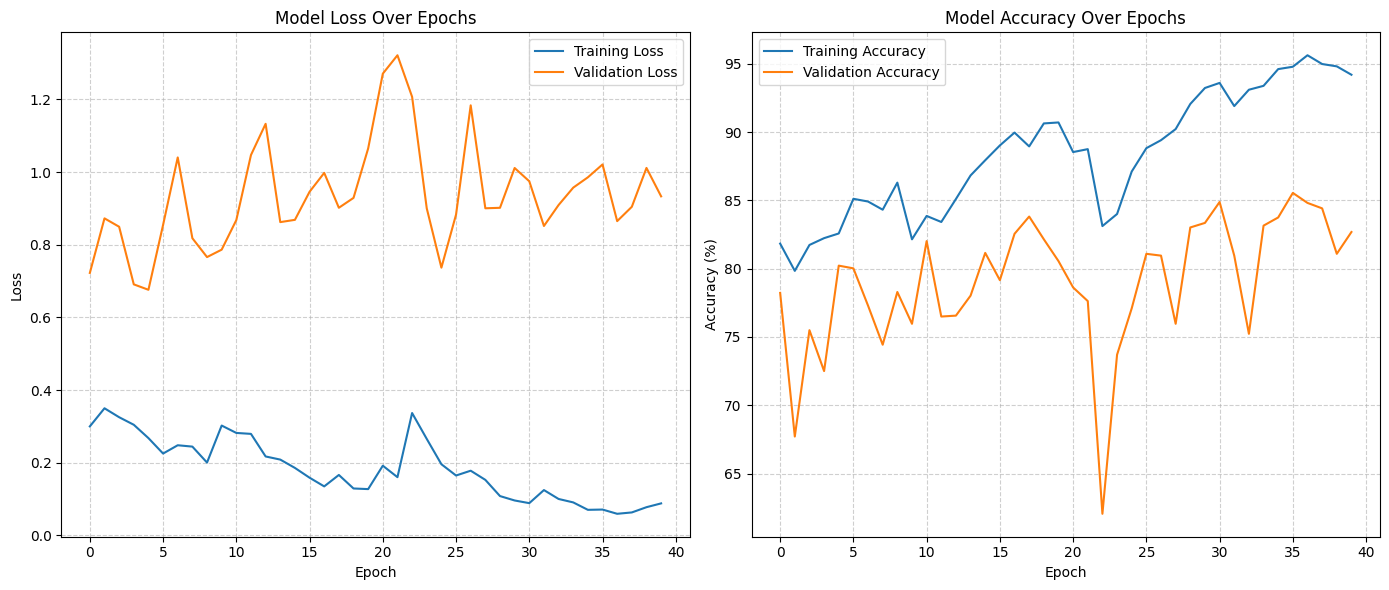

In [ ]:
import matplotlib.pyplot as plt

# --- Plotting the training and validation loss ---
plt.figure(figsize=(14, 6))

# Plot for Loss
plt.subplot(1, 2, 1)
plt.plot(train_history['loss'], label='Training Loss')
plt.plot(train_history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# Plot for Accuracy
plt.subplot(1, 2, 2)
plt.plot(train_history['accuracy'], label='Training Accuracy')
plt.plot(train_history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

✅ Best model loaded and set to evaluation mode.


Evaluating on Test Set: 100%|██████████| 6/6 [00:14<00:00,  2.47s/it]



--- FINAL MODEL PERFORMANCE ---
Test Accuracy: 84.76%

Classification Report:
              precision    recall  f1-score   support

       akiec       0.66      0.71      0.69        49
         bcc       0.77      0.79      0.78        77
         bkl       0.73      0.69      0.71       165
          df       0.77      0.59      0.67        17
         mel       0.61      0.71      0.66       167
          nv       0.93      0.91      0.92      1006
        vasc       0.90      0.82      0.86        22

    accuracy                           0.85      1503
   macro avg       0.77      0.75      0.75      1503
weighted avg       0.85      0.85      0.85      1503



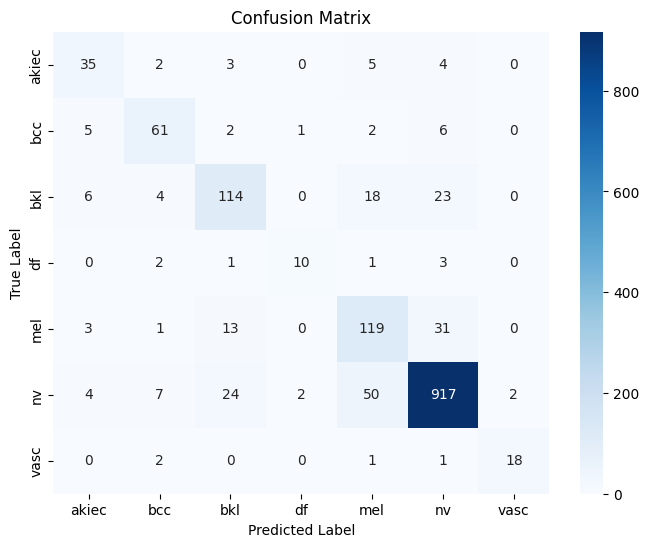

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. LOAD THE BEST MODEL ---
# Re-create the model architecture and load the saved weights
model_eval = models.resnet50()
model_eval.fc = nn.Linear(model_eval.fc.in_features, 7)
model_eval.load_state_dict(torch.load('best_model_pytorch.pth'))
model_eval = model_eval.to(device)
model_eval.eval()
print("✅ Best model loaded and set to evaluation mode.")

# --- 2. EVALUATE ON TEST SET ---
all_predictions = []
all_true_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader, desc="Evaluating on Test Set"):
        images, labels = images.to(device), labels.to(device)
        outputs = model_eval(images)
        _, predicted = torch.max(outputs.data, 1)
        all_predictions.extend(predicted.cpu().numpy())
        all_true_labels.extend(labels.cpu().numpy())

# --- 3. DISPLAY RESULTS ---
accuracy = 100 * (np.array(all_predictions) == np.array(all_true_labels)).sum() / len(all_true_labels)
print(f"\n--- FINAL MODEL PERFORMANCE ---")
print(f"Test Accuracy: {accuracy:.2f}%")
print("\nClassification Report:")
print(classification_report(all_true_labels, all_predictions, target_names=label_names))

# --- 4. PLOT CONFUSION MATRIX ---
cm = confusion_matrix(all_true_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()



---


# **Project Conclusion**

For this project, I aimed to classify 7 types of skin lesions from the imbalanced HAM10000 dataset. My initial attempt, a CNN built from scratch, struggled significantly. It achieved only **57%** accuracy and completely failed to learn the features of the rarer classes.

To solve this, I implemented a **transfer learning** strategy using a pre-trained **ResNet50** model, combined with **class weights** to handle the data imbalance. This approach proved highly effective, achieving a final test accuracy of **84.76%**. The new model successfully identified all 7 classes and showed a strong ability to detect the more critical cancerous types.

This project confirmed that for complex medical imaging, a "from scratch" model is insufficient. The success of the second approach demonstrates that the combination of powerful pre-trained features from transfer learning and a targeted strategy for class imbalance is essential for building a robust, high-performing classifier.